## Dataset generator
This notebook is configured to work with armenian language

You should start by seeing `preprocessing.ipynb`


### Main code
First cell of this notebook is just defining functions and importing dependencies, and as such can be used as a standalone module for your adaptations

In [1]:
# Author: Ankush Gupta
# Date: 2015

# Date of rework for armenian language support: 2024
# Author: Abilov Damir

"""
Entry-point for generating synthetic text images, as described in:

@InProceedings{Gupta16,
      author       = "Gupta, A. and Vedaldi, A. and Zisserman, A.",
      title        = "Synthetic Data for Text Localisation in Natural Images",
      booktitle    = "IEEE Conference on Computer Vision and Pattern Recognition",
      year         = "2016",
    }
"""

import numpy as np
import h5py
import os, sys, traceback
import os.path as osp
from SynthTextCore.synthgen import *
from SynthTextCore.common import *
import wget, tarfile
from tqdm import tqdm
import random

## Define some configuration variables:
SECS_PER_IMG = 2 #max time per image in seconds

# path to the data-file, containing image, depth and segmentation:
DATA_PATH = 'data'
DB_FNAME = osp.join(DATA_PATH,'dset.h5')
# url of the data (google-drive public file):
DATA_URL = 'http://www.robots.ox.ac.uk/~ankush/data.tar.gz'
OUT_FILE = 'results/SynthText.h5'

# Disabled automatic download of useless models - should just instruct user to see preprocessing.ipynb 
def get_data():
  # """
  # Download the image,depth and segmentation data:
  # Returns the h5 database.
  # """
  # if not osp.exists(DB_FNAME):
  #   try:
  #     colorprint(Color.BLUE,'\tdownloading data (56 M) from: '+DATA_URL,bold=True)
  #     print()
  #     sys.stdout.flush()
  #     out_fname = 'data.tar.gz'
  #     wget.download(DATA_URL,out=out_fname)
  #     tar = tarfile.open(out_fname)
  #     tar.extractall()
  #     tar.close()
  #     os.remove(out_fname)
  #     colorprint(Color.BLUE,'\n\tdata saved at:'+DB_FNAME,bold=True)
  #     sys.stdout.flush()
  #   except:
  #     print (colorize(Color.RED,'Data not found and have problems downloading.',bold=True))
  #     sys.stdout.flush()
  #     sys.exit(-1)

  if not osp.exists(DB_FNAME):
    print(DB_FNAME, "doesn't exist, you likely didn't set up project properly. See preprocessing.ipynb for instructions.")
  # open the h5 file and return:
  return h5py.File(DB_FNAME,'r')


def add_res_to_db(imgname,res,db):
  """
  Add the synthetically generated text image instance
  and other metadata to the dataset.
  """
  ninstance = len(res)
  for i in range(ninstance):
    dname = "%s_%d"%(imgname, i)
    db['data'].create_dataset(dname,data=res[i]['img'])
    db['data'][dname].attrs['charBB'] = res[i]['charBB']
    db['data'][dname].attrs['wordBB'] = res[i]['wordBB']        
    #db['data'][dname].attrs['txt'] = res[i]['txt']
    L = res[i]['txt']
    L = [n.encode("utf-8") for n in L]
    db['data'][dname].attrs['txt'] = L

def main(db, num_img, instances_per_img, mode):
  # open the output h5 file:
  try:
    os.mkdir("results/")
  except OSError:
    print("'results/' already exists")
  out_db = h5py.File(OUT_FILE,'w')
  try:
    out_db.create_group('/data')
    print (colorize(Color.GREEN,'Storing the output in: '+OUT_FILE, bold=True))
    
    imnames = list(db['image'].keys())
    # If mode == 'random', uses num_img random indexies
    random_indexes = list(range(len(imnames)))
    random.shuffle(random_indexes)
    iterator = tqdm(
      random_indexes[:num_img] if mode == 'random' else range(num_img),
      desc="Going through images...",
      total=num_img
    )

    RV3 = RendererV3(DATA_PATH,max_time=SECS_PER_IMG)
    for i in iterator:
      imname = imnames[i]
      # get the image:
      img = Image.fromarray(db['image'][imname][:])
      # get the pre-computed depth:
      #  there are 2 estimates of depth (represented as 2 "channels")
      #  here we are using the second one (in some cases it might be
      #  useful to use the other one):
      depth = db['depth'][imname][:].T
      depth = depth[:,:,1]
      # get segmentation:
      seg = db['seg'][imname][:].astype('float32')
      area = db['seg'][imname].attrs['area']
      label = db['seg'][imname].attrs['label']

      # re-size uniformly:
      sz = depth.shape[:2][::-1]
      ##img = np.array(img.resize(sz,Image.ANTIALIAS))
      img = np.array(img.resize(sz,Image.LANCZOS))#ANTIALIAS was removed in Pillow 10.0.0
      seg = np.array(Image.fromarray(seg).resize(sz,Image.NEAREST))

      # update the iterator progress bar
      iterator.set_description(f"Generating {instances_per_img} images of {imname}")
      res = RV3.render_text(img,depth,seg,area,label,
                            ninstance=instances_per_img,viz=False)
      if len(res) > 0:
        # non-empty : successful in placing text:
        add_res_to_db(imname,res,out_db)
      
  finally:
    db.close()
    out_db.close()


pygame 2.6.1 (SDL 2.28.4, Python 3.13.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\Home\Desktop\SID\printed_text_ocr_generator_hye-main\first\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Using the generator
This cell will:
  - download small sample dataset of images, if there is no `data/dset.h5`
    - along with that it replaces any files in `data/` with original (english) settings
    - if you want to run it with armenian, substitute folders in `data/` with custom ones from `data AM substitution/`
    - if there is already `data/dset.h5`, it will be used instead
  - ask you how many images from `data/dset.h5` do you want to use
  - ask you how many variants do you want generated per image
  - ask you how do you want to choose images from `data/dset.h5`
    - 'r': random mode, images will be used in random order (without repetitions)
    - 'o': ordered mode, images will be used in alphabetical order
  - show progress of placing text on images
  - save images with text to another dataset `results/SynthText.h5`, now containing:
    - images themselves
    - text on each individual one
    - bounding boxes of words and individual letters

In [2]:
if __name__ == "__main__":
    print (colorize(Color.BLUE,'getting data..',bold=True))
    db = get_data()
    print (colorize(Color.BLUE,'\t-> done',bold=True))
    N = len(db['image'].keys())

    print(f"Images available in `data/dset.h5`: ~{N} \
                \nHow many do you want to use for generation? (-1 = ALL)\n>>>")
    num_img = int(input())
    num_img = N if num_img < 0 else min(max(1,num_img), N)

    print(f"\n{num_img} different images will be used. \
                \nHow many versions do you want per 1 image?\n>>>")
    instances_per_img = int(input())
    instances_per_img = max(1, instances_per_img)


    print("\nChoose mode: \nr=random images will be used, \
           \n[anything else]=images will be used in alphabetical order\n>>>")
    if 'r' == input().lower():
        mode = 'random'
    else:
        mode = 'order'

    main(db, num_img, instances_per_img, mode)

    

getting data..
	-> done
Images available in `data/dset.h5`: ~5                 
How many do you want to use for generation? (-1 = ALL)
>>>


 -1



5 different images will be used.                 
How many versions do you want per 1 image?
>>>


 1



Choose mode: 
r=random images will be used,            
[anything else]=images will be used in alphabetical order
>>>


 r


'results/' already exists
Storing the output in: results/SynthText.h5


Generating 1 images of hiking_125.jpg:   0%|                                                     | 0/5 [00:00<?, ?it/s]C:\Users\Home\Desktop\SID\printed_text_ocr_generator_hye-main\SynthTextCore\synthgen.py:463: RuntimeWarning: divide by zero encountered in divide
  asp0 = hw0[:,0]/hw0[:,1]
C:\Users\Home\Desktop\SID\printed_text_ocr_generator_hye-main\SynthTextCore\synthgen.py:464: RuntimeWarning: divide by zero encountered in divide
  asp = hw[:,0]/hw[:,1]
C:\Users\Home\Desktop\SID\printed_text_ocr_generator_hye-main\SynthTextCore\synthgen.py:467: RuntimeWarning: invalid value encountered in scalar divide
  asp_ratio = asp/asp0
Generating 1 images of indian+musicians_116.jpg:  20%|███████                            | 1/5 [00:01<00:06,  1.61s/it]

   *** Timed out!
   *** Timed out!


Generating 1 images of sandwich_96.jpg:  40%|█████████████████▌                          | 2/5 [00:10<00:17,  5.85s/it]

   *** Timed out!


Generating 1 images of sea_15.jpg: 100%|█████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.88s/it]


## Visualizing generated images

This notebook takes generated images from `results/SynthText.h5` and displays them with various settings

In [3]:

from __future__ import division
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt 
import h5py 
from SynthTextCore.common import *


def viz_textbb(text_im, charBB_list, wordBB, alpha=1.0):
    """
    text_im : image containing text
    charBB_list : list of 2x4xn_i bounding-box matrices
    wordBB : 2x4xm matrix of word coordinates
    """
    plt.close(1)
    plt.figure(1)
    plt.imshow(text_im)
    H,W = text_im.shape[:2]

    # plot the character-BB:
    for i in range(len(charBB_list)):
        bbs = charBB_list[i]
        ni = bbs.shape[-1]
        for j in range(ni):
            bb = bbs[:,:,j]
            bb = np.c_[bb,bb[:,0]]
            plt.plot(bb[0,:], bb[1,:], 'r', alpha=alpha/2)

    # plot the word-BB:
    wordBB = np.asarray(wordBB)
    if wordBB.any():
        for i in range(wordBB.shape[-1]):
            bb = wordBB[:,:,i]
            bb = np.c_[bb,bb[:,0]]
            plt.plot(bb[0,:], bb[1,:], 'g', alpha=alpha)
            
            # remove comment to visualize the individual vertices:
            # vcol = ['r','g','b','k']
            # for j in range(4):
            #     plt.scatter(bb[0,j],bb[1,j],color=vcol[j])        

    plt.gca().set_xlim([0,W-1])
    plt.gca().set_ylim([H-1,0])
    plt.show(block=True)

def main2(db, num_images, no_delay_render, render_word_BBs, render_char_BBs):
    dsets = sorted(db['data'].keys())
    for k in dsets:
        rgb = db['data'][k][...]
        charBB = db['data'][k].attrs['charBB']
        wordBB = db['data'][k].attrs['wordBB']
        txt = db['data'][k].attrs['txt']

        print ("image name        : ", colorize(Color.BLUE, k, bold=True))
        print ("  ** no. of chars : ", colorize(Color.YELLOW, charBB.shape[-1]))
        print ("  ** no. of words : ", colorize(Color.YELLOW, wordBB.shape[-1]))
        print ("  ** text         : ", [str.encode(word).decode('utf-8') for word in txt])
        viz_textbb(
            rgb, 
            [charBB] if render_char_BBs else [], 
            wordBB if render_word_BBs else []
        )
        num_images -= 1
        if num_images == 0:
            break
        if no_delay_render:
            continue
        if 'q' in input("next? ('q' to exit) : "):
            break
    db.close()


### Entry point
Run the notebook from here.
You have the options for rendering all at once or one by one; rendering bounding boxes of words and letters or not

total number of images :  5
How many of them do you want to see?
>>>


 5


Slow down?
n: will render all the images at once [Caution! It's not a good idea for large amount of images]       
[anything else]: will wait for user input before rendering the next image
>>>


 n



Render word bounding boxes?
y: will render word BBs       
[anything else]: won't render word BBs
>>>


 y



Render character bounding boxes?
y: will render character BBs       
[anything else]: won't render character BBs
>>>


 b


image name        :  hiking_125.jpg_0
  ** no. of chars :  12
  ** no. of words :  2
  ** text         :  ['ХїХёЦ‚ЦЂ', 'ХёЦ‚']


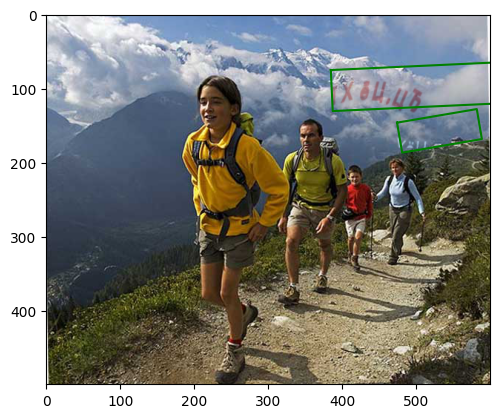

image name        :  indian+musicians_116.jpg_0
  ** no. of chars :  17
  ** no. of words :  4
  ** text         :  ['ХёЦ‚\nХґХЁ,', 'ХЇХЁ\nХёЦЂ']


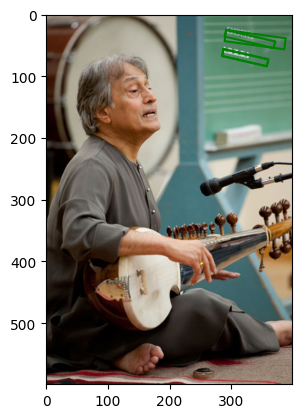

image name        :  sandwich_96.jpg_0
  ** no. of chars :  4
  ** no. of words :  1
  ** text         :  ['ХёЦ‚']


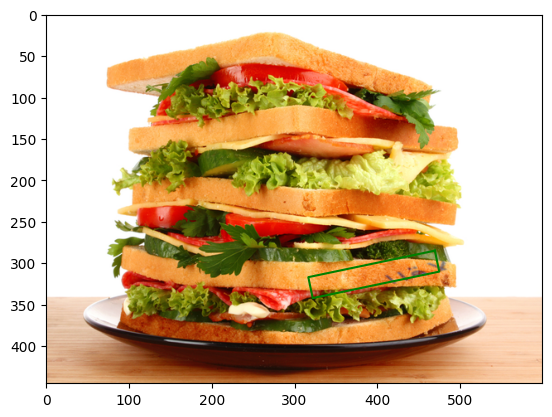

image name        :  sea_15.jpg_0
  ** no. of chars :  7
  ** no. of words :  2
  ** text         :  ['3 Ф»ХЅХЇ']


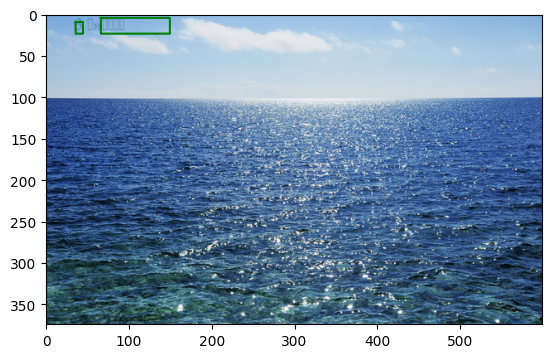

image name        :  village_43.jpg_0
  ** no. of chars :  19
  ** no. of words :  4
  ** text         :  ['ХёХ›Хѕ', 'ХґХЁ:\nХёЦЂ ', 'ХёЦЂ']


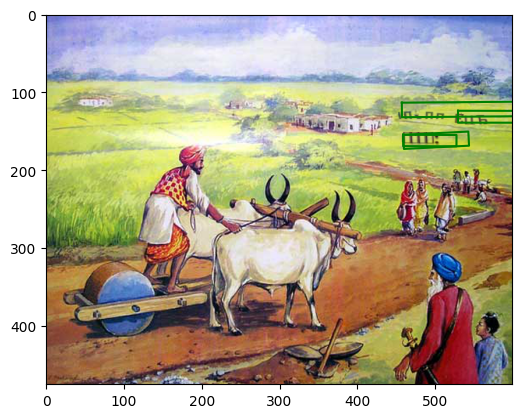

In [4]:
if __name__=='__main__':
    db = h5py.File('results/SynthText.h5', 'r')
    N = len(db['data'].keys())
    print ("total number of images : ", colorize(Color.RED, N, bold=True))
    
    print("How many of them do you want to see?\n>>>")
    num_images = min(max(1, int(input())), N) 

    print("Slow down?\nn: will render all the images at once [Caution! It's not a good idea for large amount of images] \
      \n[anything else]: will wait for user input before rendering the next image\n>>>")
    no_delay_render = True if input().lower() == 'n' else False

    print("\nRender word bounding boxes?\ny: will render word BBs \
      \n[anything else]: won't render word BBs\n>>>")
    render_word_BBs = True if input().lower() == 'y' else False

    print("\nRender character bounding boxes?\ny: will render character BBs \
      \n[anything else]: won't render character BBs\n>>>")
    render_char_BBs = True if input().lower() == 'y' else False

    main2(db, num_images, no_delay_render, render_word_BBs, render_char_BBs)